● Setup 1A - You are required to train a BERT model (google-bert/bert-base-uncased ·
Hugging Face) using HuggingFace for the task of Text Similarity. You are required to
obtain BERT embeddings while making use of a special token used by BERT for
separating multiple sentences in an input text and an appropriate linear layer or setting
of BertForSequenceClassification (BERT) framework for a float output. Choose a
suitable loss function. Report the required evaluation metric on the validation set.

In [1]:
#Import necessary libraries
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from scipy.stats import pearsonr
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt

device = torch.device("cpu")

print("PyTorch version:", torch.__version__)
print("Device:", device)

#Writing a Dataloader to fetch input_ids, attention mask of tokens of sentences
class SimilarityofSentences(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.sentence1 = dataframe.sentence1
        self.sentence2 = dataframe.sentence2
        self.targets = self.data.score
        self.max_length = max_length

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        sentence1 = str(self.sentence1[index])
        sentence2 = str(self.sentence2[index])
        target = self.targets[index]
        inputs = self.tokenizer.encode_plus(
            sentence1,
            sentence2,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "labels": torch.tensor(target, dtype=torch.float),
        }

/home/pypixel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.2.2+cu121
Device: cpu


In [2]:
#loading and preparing dataset using above defined class
train_data = pd.read_csv("train.csv", delimiter='\t')
dev_data = pd.read_csv("dev.csv", delimiter='\t')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = SimilarityofSentences(train_data, tokenizer, max_length=128)
dev_dataset = SimilarityofSentences(dev_data, tokenizer, max_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=8)

model = BertForSequenceClassification.from_pretrained("1a_model")

# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
# model.to(device)
# train_data

In [3]:
def evaluate(validation_loader):
    model.eval()
    predictions, true_labels = [], []
    for batch in tqdm(validation_loader, desc="Predicting on validation set"):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        embeddings = outputs.logits.detach().cpu().numpy()
        target_ID = batch['labels'].to('cpu').numpy()
        predictions.append(embeddings)
        true_labels.append(target_ID)
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    return predictions, true_labels
Prediction, true_labels = evaluate(dev_dataloader)
Pearson_correlation = pearsonr(Prediction.flatten(), true_labels.flatten())
print(f"Pearson Correlation on Setup 1A: {Pearson_correlation[0]}")

Predicting on validation set:  72%|███████▏  | 133/184 [01:08<00:26,  1.89it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Predicting on validation set: 100%|██████████| 184/184 [01:35<00:00,  1.92it/s]

Pearson Correlation on Setup 1A: 0.8755226911049


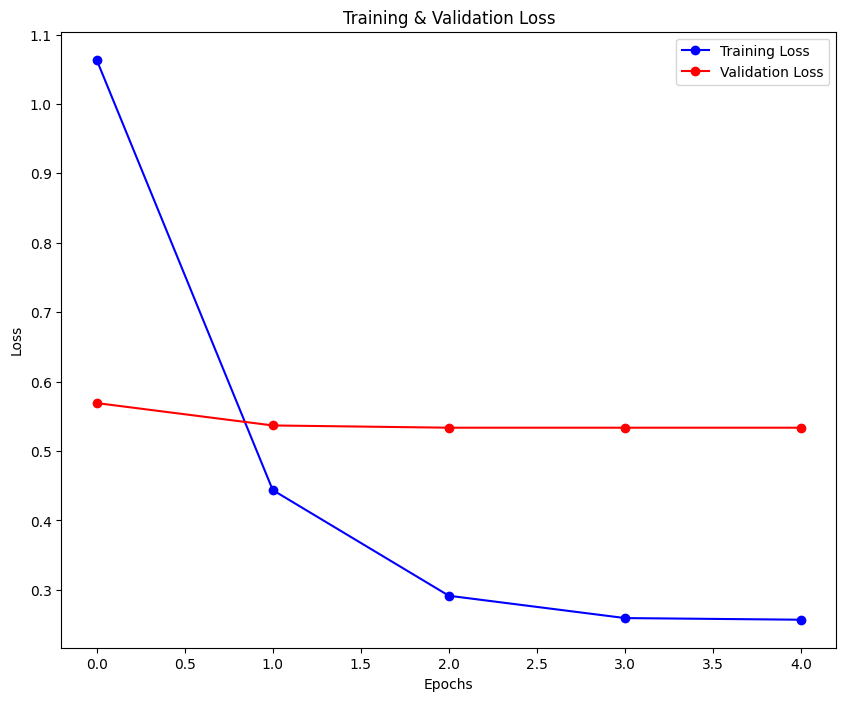

In [4]:
import pickle
import matplotlib.pyplot as plt
file_path1 = "1A_train.pkl"
file_path2 = "1A_val.pkl"
# Loading the pickle file and reading its contents
with open(file_path1, 'rb') as f:
    train_losses = pickle.load(f)
with open(file_path2, 'rb') as f:
    val_losses = pickle.load(f)
# print("Contents of the loaded list:")
# print(train_losses)
# print(val_losses)
plt.figure(figsize=(10, 8))
plt.plot(train_losses, 'b-o', label="Training Loss")
plt.plot(val_losses, 'r-o', label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Setup 1B - You are required to make use of the Sentence-BERT model
(https://arxiv.org/pdf/1908.10084.pdf) and the SentenceTransformers framework
(Sentence-Transformers). For this setup, make use of the Sentence-BERT model to
encode the sentences and determine the cosine similarity between these embeddings
for the validation set. Report the required evaluation metric on the validation set.

In [5]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

df_dev = pd.read_csv("dev.csv", delimiter='\t')

# make my GPU invisible 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


model = SentenceTransformer("1b_model")

embeddings1 = model.encode(df_dev['sentence1'].tolist(), convert_to_tensor=True)
embeddings2 = model.encode(df_dev['sentence2'].tolist(), convert_to_tensor=True)

cosine_similarities = util.pytorch_cos_sim(embeddings1, embeddings2).diag().cpu().numpy()
scaled_cosine_similarities = cosine_similarities * 5

pearson_corr = pearsonr(scaled_cosine_similarities, df_dev['score'].values)
print(f"Pearson Correlation on Setup 1B: {pearson_corr[0]}")

Pearson Correlation on Setup 1B: 0.8721286091027513


Setup 1C - In this setup, you must fine-tune the Sentence-BERT model for the task of
STS. Make use of the CosineSimilarityLoss function (Losses — Sentence-Transformers
documentation). Report the required evaluation metric on the validation set—reference:
Semantic Textual Similarity — Sentence-Transformers documentation. You must train for
at least two epochs and surpass the performance of Setup 2B.

In [6]:
from sentence_transformers import SentenceTransformer, InputExample, losses, datasets, evaluation
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import os
from sentence_transformers import util


train_df = pd.read_csv('train.csv', delimiter='\t').fillna('')
dev_df = pd.read_csv('dev.csv', delimiter='\t').fillna('')
train_df['sentence1'], train_df['sentence2'] = train_df['sentence1'].astype(str), train_df['sentence2'].astype(str)
dev_df['sentence1'], dev_df['sentence2'] = dev_df['sentence1'].astype(str), dev_df['sentence2'].astype(str)

#Preparing train examples, dev examples and scale the cosine similarity to the score column's scale before evaluation.

train_examples = []
for index, row in train_df.iterrows():
    texts = [row['sentence1'], row['sentence2']]
    label = row['score'] / 5
    train_examples.append(InputExample(texts=texts, label=label))
dev_examples = []
for index, row in dev_df.iterrows():
    texts = [row['sentence1'], row['sentence2']]
    label = row['score'] / 5
    dev_examples.append(InputExample(texts=texts, label=label))

In [7]:
model = SentenceTransformer("1c_model")

train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=1)
train_loss = losses.CosineSimilarityLoss(model)

evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(dev_examples, batch_size=1)

In [8]:
from tqdm.auto import tqdm
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(dev_examples, batch_size=8)

model.eval()
predictions = []
labels = []

for example in tqdm(dev_examples, desc="Evaluating", unit="example"):
    embedding1 = model.encode(example.texts[0], convert_to_tensor=True)
    embedding2 = model.encode(example.texts[1], convert_to_tensor=True)
    
    cosine_similarty = util.pytorch_cos_sim(embedding1, embedding2)
    predictions.append(cosine_similarty.item())
    
    labels.append(example.label)

predictions = np.array(predictions) * 5
labels = np.array(labels) * 5

pearson_corr = pearsonr(predictions, labels)
print(f'Pearson Correlation on Setup 1C: {pearson_corr[0]}')

Evaluating: 100%|██████████| 1470/1470 [01:07<00:00, 21.81example/s]

Pearson Correlation on Setup 1C: 0.8964360233190518


In [9]:
#loading saved model for making prediction on test.csv and saving generating sample_demo.csv
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer, util


test_data = pd.read_csv("sample_test.csv", delimiter='\t')
print(test_data.columns)

def generate_predictions(model, test_data):
    predictions = []
    
    for idx, row in tqdm(test_data.iterrows(), desc="Generating Predictions", total=len(test_data)):
        embedding1 = model.encode(row['sentence1'], convert_to_tensor=True)
        embedding2 = model.encode(row['sentence2'], convert_to_tensor=True)

        cos_sim = util.pytorch_cos_sim(embedding1, embedding2)
        similarity_score = cos_sim.item() * 5
        
        predictions.append({
            'id': row['id'],
            'score': similarity_score,
            'sentence1': row['sentence1'],
            'sentence2': row['sentence2']
        })
    
    return predictions

predictions = generate_predictions(model, test_data)
for prediction in predictions:
    prediction['score'] = round(prediction['score'], 3)
output_df = pd.DataFrame(predictions)
output_df.to_csv('sample_demo_gen2.csv', index=False, sep='\t')

Index(['id', 'sentence1', 'sentence2'], dtype='object')


Generating Predictions: 100%|██████████| 6/6 [00:00<00:00, 24.98it/s]


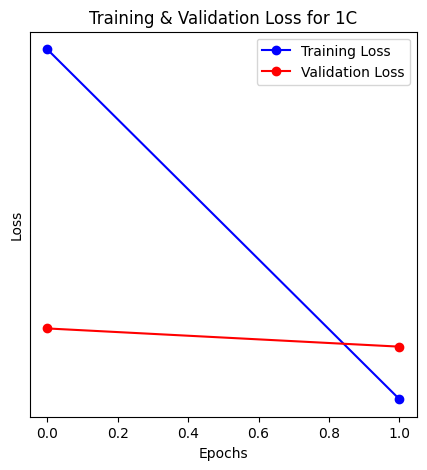

In [12]:
import pickle
import matplotlib.pyplot as plt
file_path1 = "1C_train.pkl"
file_path2 = "1C_val.pkl"
# Loading the pickle file and reading its contents
with open(file_path1, 'rb') as f:
    train_losses = pickle.load(f)
with open(file_path2, 'rb') as f:
    val_losses = pickle.load(f)
# print("Contents of the loaded list:")
# print(train_losses)
# print(val_losses)
plt.figure(figsize=(5, 5))
plt.plot(train_losses, 'b-o', label="Training Loss")
plt.plot(val_losses, 'r-o', label="Validation Loss")
plt.title("Training & Validation Loss for 1C")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yticks([])
plt.legend()
plt.show()

In [2]:
# TASK-2

In [ ]:
# RUN 2A : code can be seen from infer2A.ipynb
%run './A3_24_infer_2a.ipynb'

In [ ]:
# RUN 2B and 2C : code can be seen from A3_24_infer_Q2_2_3 .ipynb
%run 'A3_24_infer_2B_2C.ipynb'